In [1]:
import numpy as np
from scipy.linalg import qr

n, r = 100, 10
rng = np.random.default_rng(123)

# fixed orthonormal U_A
U_A, _ = qr(rng.standard_normal((n, r)), mode='economic')

target_lo, target_hi = 0.90, 0.97          # sigma_min window
eps_grid            = np.linspace(0, 0.40, 500000)

good_matrices = []
epsilons = []

for eps in eps_grid:
    # random noise in the orthogonal complement of U_A
    E = rng.standard_normal((n, r))
    E = E - U_A @ (U_A.T @ E)               # make E perp to span(U_A)
    V_candidate = U_A + eps * E             # epsilon–perturbation
    V_A, _ = qr(V_candidate, mode='economic')

    sigma_min = np.linalg.svd(U_A.T @ V_A, compute_uv=False)[-1]
    if target_lo <= sigma_min < target_hi:
        good_matrices.append(V_A)
        epsilons.append(1 - sigma_min)
        

print("Number of viable matrices:", len(good_matrices))

sing_vals_A = [1e-7, 1e-7, 1e-7, 1e-2, 1e-2, 1e-2, 1e-1, 1, 1e1, 1e2]
sing_vals_A = sing_vals_A[::-1]

tilde_eps = []
tri_ineq_1 = []
tri_ineq_2 = []
"""

for k, good_matrix in enumerate(good_matrices):

    A = U_A @ np.diag(sing_vals_A) @ good_matrix.T # made an \epsilon near symmetric matrix

    X = np.random.randn(n,r)

    AX = A @ X

    A_nyst = (AX) @ np.linalg.inv(X.T @ AX) @ (AX).T

    Q_X, _ = qr(X)

    proj_XT = Q_X @ Q_X.T

    orth_proj_XT = np.eye(n) - proj_XT

    G = np.random.rand(n,r)

    symm_matrix = 0.5 * (G @ G.T)

    W = orth_proj_XT @ symm_matrix @ orth_proj_XT # by making a symmetric perturbation, we aim to preserve the epsilon symmetry of A

    BX = A @ (np.eye(n) + W) @ X

    bound = np.linalg.norm(AX - A_nyst @ X,2)

    tri_ineq_1.append(bound)

    B_nystX = A_nyst @ (np.eye(n) + W) @ X

    bound_2 = np.linalg.norm(B_nystX - AX)

    tri_ineq_2.append(bound_2)

print("supremum of both sets: ", max(tri_ineq_1), max(tri_ineq_2))
"""

for j, matrix in enumerate(good_matrices):

    alphas = np.linspace(1e-10, 1e-1, 100000)
    B_tildas = []

    A = U_A @ np.diag(sing_vals_A) @ matrix.T # epsilon near symmetry

    X = np.random.randn(n,r)

    AX = A @ X

    A_nyst = (AX) @ np.linalg.inv(X.T @ AX) @ (AX).T

    Q_X, _ = qr(X)

    proj_XT = Q_X @ Q_X.T

    orth_proj_XT = np.eye(n) - proj_XT

    G = np.random.rand(n,r)

    symm_matrix = 0.5 * (G @ G.T)

    W = orth_proj_XT @ symm_matrix @ orth_proj_XT # by making a symmetric perturbation, we aim to preserve the epsilon symmetry of A (make sure true)

    for i, alpha in enumerate(alphas):

        B = A_nyst @ (np.eye(n) + alpha * W)

        B_tildas.append(B)

        supremum_estimate = np.linalg.norm(A - B)

        tri_ineq_1.append(supremum_estimate)

    # From numerical experiments, I have found that sup|| A - A^|| ~= sup||A - B^||

    supremum = 2 * np.max(tri_ineq_1)

    print(supremum)

    svd_for_c = np.linalg.svd(X.T @ matrix, compute_uv= False)

    sigma_mimimum = svd_for_c[-1]
    sigma_maximum = svd_for_c[0]

    c = sigma_maximum / (sigma_mimimum) ** 2

    gamma = np.sqrt(8 * epsilon)


    if c * gamma < 1:

        RHS = 4 * np.linalg.norm(AX) * (c**2 gamma) / (1 - c * gamma)

        RHS_bound.append(RHS)








<>:37: SyntaxWarning: invalid escape sequence '\e'
<>:37: SyntaxWarning: invalid escape sequence '\e'
C:\Users\aleks\AppData\Local\Temp\ipykernel_60104\3425128002.py:37: SyntaxWarning: invalid escape sequence '\e'
  """


SyntaxError: invalid syntax (3425128002.py, line 129)

4 of 80 violations
1817
109800


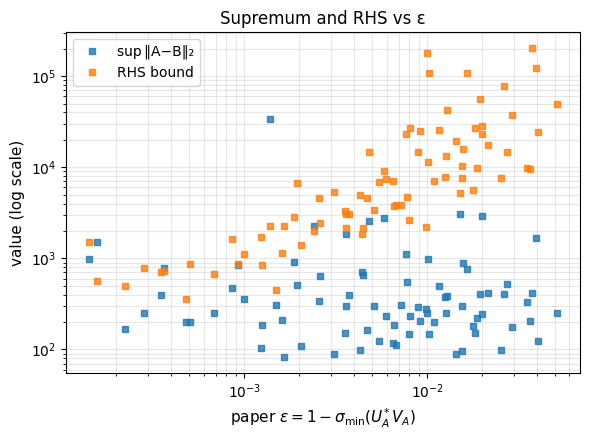

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr, expm, svd, norm, null_space

n, r        = 100, 20
p = 20

embed = True

rng         = np.random.default_rng(123)

U_A, _      = qr(rng.standard_normal((n, r)), mode='economic')

eps_grid    = np.linspace(0.0, 0.40, 2000)

target_low, target_high = 0.90, 0.9999

sing_vals_A = np.logspace(-7, 2, r)[::-1]

Sigma = np.diag(sing_vals_A)


eps_paper  = []
supremum   = []
rhs_bound  = [] 

alphas     = np.logspace(-4, -1, 600)

rejected_matrices = 0
B_accepted_matrices = 0

for eps_injected in eps_grid:

    #build a V_A s.t. it is epsilon close
    E  = rng.standard_normal((n, r))
    E -= U_A @ (U_A.T @ E)
    V_A, _ = qr(U_A + eps_injected*E, mode='economic')

    sigma_min = svd(U_A.T @ V_A, compute_uv=False)[-1]
    if not (target_low <= sigma_min < target_high):
        rejected_matrices += 1
        continue                              # outside the sigma_min band

    epsilon_paper = 1.0 - sigma_min          # this is the "paper epsilon"
    
    X = np.random.randn(n,r+p)

    Q_full, R_full   = np.linalg.qr(X, mode = 'complete')

    k_rank = X.shape[1] # rank of matrix
    Q = Q_full[:, :k_rank] # Q in thin QR factorisation
    Q_perp = Q_full[:, k_rank:] # Q_perp from full QR fact.

    # make A and approximant A_nyst.
    A        = U_A @ Sigma @ V_A.T
    AX       = A @ X
    A_nyst   = AX @ np.linalg.inv(X.T @ AX) @ AX.T

    max_goes = 1000

    n_perp = Q_perp.shape[1]                 #  n - rank(X)
    for _ in range(max_goes):
        Gsym = rng.standard_normal((n_perp, n_perp))
        Gsym = 0.5 * (Gsym + Gsym.T)
        Gsym += 1e-4 * np.eye(n_perp)        # ridge to ensure SPD
        if np.linalg.matrix_rank(Gsym) == n_perp:
            break                            # <-- we KEEP this SPD matrix
    else:
        raise RuntimeError("no full-rank Gsym")

    have_good = False
    sup_val   = 0.0
    B_best    = None

    W = Q_perp @ Gsym @ Q_perp.T

    for alph in alphas:

        B = A_nyst + alph * W

        U_B, _, Vt_B = svd(B, full_matrices=False)

        sigma_min_UBVB  = svd(U_B.T @ Vt_B.T, compute_uv=False)[-1]

        norm_AX_A_nystX = np.linalg.norm(AX - A_nyst @ X, 2)
        norm_A_nyst_BX = np.linalg.norm(A_nyst @ X - B @ X)

        if (1.0 - sigma_min_UBVB >= 1.2 * epsilon_paper) and (abs(norm_A_nyst_BX - norm_AX_A_nystX) <= 1e-10):
             # call this delta? I have realised it might not be the case \tilde{A} is epsilon near symm
            continue                # need to make sure these are also epsilon near symmatric as I dont know if thats guaranteed?

        B_accepted_matrices += 1

        # accept and possibly update the current best
        val = norm(A - B, 2)
        if val > sup_val:
            sup_val = val
            B_best  = B

    # no alpha produced an acceptable B  ->  skip this epsilon
    if B_best is None:
        continue

    # RHS of thm 4
    s_vals     = svd(X.T @ V_A, compute_uv=False)
    c_val      = s_vals[0] / s_vals[-1]**2
    gamma_val  = (8.0 * epsilon_paper) ** 0.5

    if c_val * gamma_val >= 0.98:
        # premise fails – skip this epsilon
        continue

    rhs_val = 4.0 * norm(AX, 2) * (c_val**2 * gamma_val) / (1.0 - c_val * gamma_val)

    eps_paper.append(epsilon_paper)
    supremum.append(sup_val)
    rhs_bound.append(rhs_val)


# ------------------------------------------------------------------
# Plot Supremum vs RHS  (log–log)
# ------------------------------------------------------------------
eps_paper   = np.array(eps_paper)
supremum    = np.array(supremum)
rhs_bound   = np.array(rhs_bound)

violation = supremum > rhs_bound
print(np.count_nonzero(violation), "of", len(eps_paper), "violations")

print(rejected_matrices)
print(B_accepted_matrices)

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.loglog(eps_paper, supremum, 's',  label="sup ‖A−B‖₂",
          markersize=4, alpha=0.8)
finite   = np.isfinite(rhs_bound)
ax.loglog(eps_paper[finite], rhs_bound[finite], 's',
          label="RHS bound", markersize=4, alpha=0.8)

ax.set_xlabel(r"paper $\varepsilon = 1-\sigma_{\min}(U_A^{\!*}V_A)$", fontsize=11)
ax.set_ylabel(r"value (log scale)", fontsize=11)
ax.set_title("Supremum and RHS vs ε", fontsize=12)
ax.grid(True, which='both', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
